## Tensorflow Tutorial
### Visual and analysis layers output

#### Flowchart

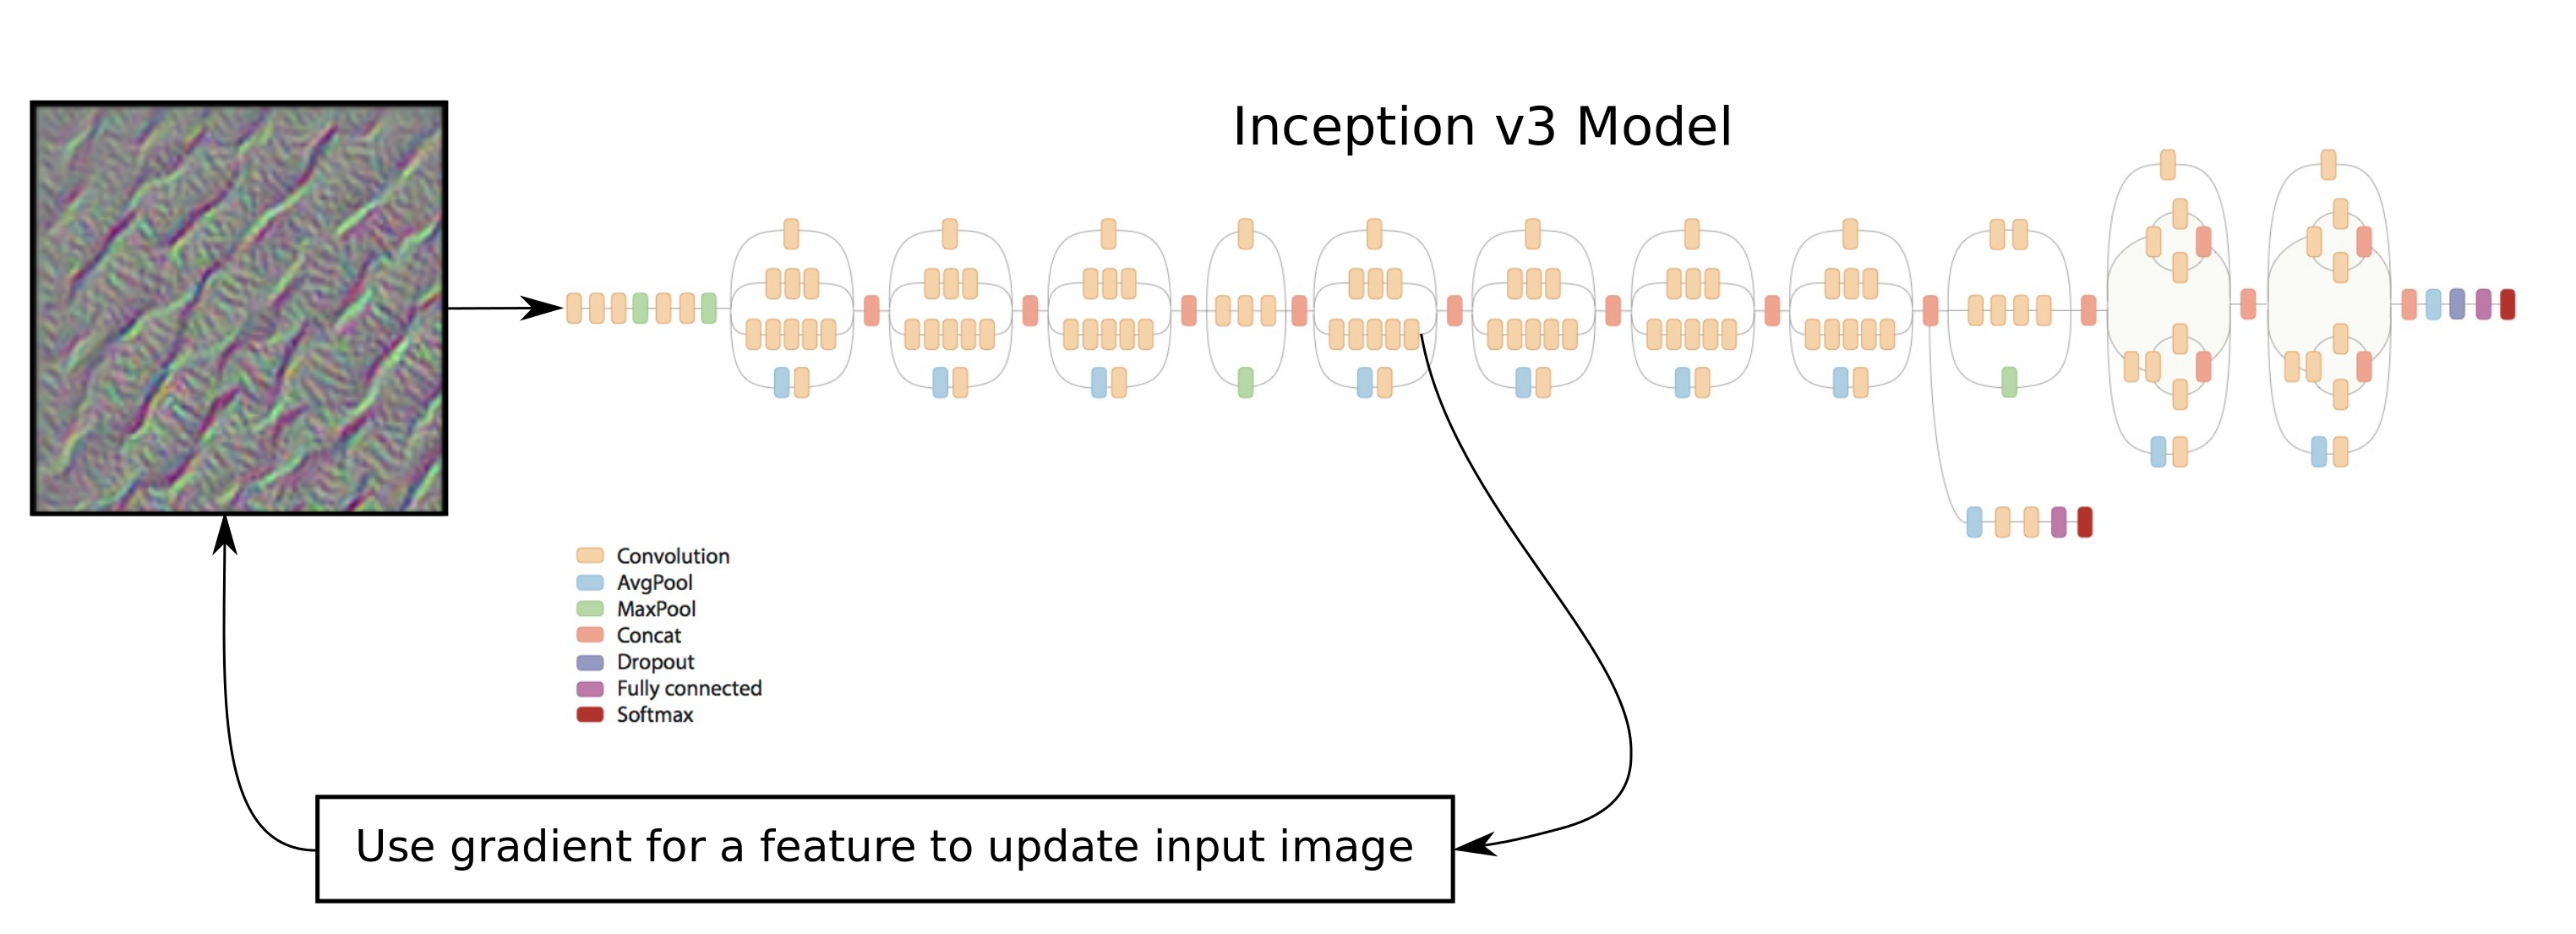

In [1]:
from IPython.display import Image, display
Image('D:\\jupyter\\tensorflow_tutorial\images\\13_visual_analysis_flowchart.png')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
import inception

c:\deeplearning\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Inception model

In [3]:
inception.data_dir = 'D:\\jupyter\\tensorflow_tutorial\CH12_Visual_and_analysis_layers\\inception'

In [4]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


#### Names of convolutional layers

In [5]:
def get_conv_layer_names():
    #load the Inception model.
    model = inception.Inception()
    
    #Create a list of names for the operations in the graph
    #for the Inception model where the operator-type is 'Conv2D'.
    names = [op.name for op in model.graph.get_operations() if op.type == 'Conv2D']
    
    #Close the tensorflow session inside the model-object.
    model.close()
    
    return names

In [6]:
conv_names = get_conv_layer_names()

In [7]:
len(conv_names)

94

In [8]:
conv_names[:5]

['conv/Conv2D',
 'conv_1/Conv2D',
 'conv_2/Conv2D',
 'conv_3/Conv2D',
 'conv_4/Conv2D']

In [9]:
conv_names[-5:]

['mixed_10/tower_1/conv/Conv2D',
 'mixed_10/tower_1/conv_1/Conv2D',
 'mixed_10/tower_1/mixed/conv/Conv2D',
 'mixed_10/tower_1/mixed/conv_1/Conv2D',
 'mixed_10/tower_2/conv/Conv2D']

#### Helper-function for finding the input image.

In [10]:
def optimize_image(conv_id=None, feature=0,
                  num_iterations=30, show_progress=True):
    """
    Find an image that maximizes the feature
    given by the conv_id and feature number.

    Parameters:
    conv_id: Integer identifying the convolutional layer to
             maximize. It is an index into conv_names.
             If None then use the last fully-connected layer
             before the softmax output.
    feature: Index into the layer for the feature to maximize.
    num_iteration: Number of optimization iterations to perform.
    show_progress: Boolean whether to show the progress.
    """

    # Load the Inception model. This is done for each call of
    # this function because we will add a lot to the graph
    # which will cause the graph to grow and eventually the
    # computer will run out of memory.
    model = inception.Inception()

    # Reference to the tensor that takes the raw input image.
    resized_image = model.resized_image

    # Reference to the tensor for the predicted classes.
    # This is the output of the final layer's softmax classifier.
    y_pred = model.y_pred

    # Create the loss-function that must be maximized.
    if conv_id is None:
        # If we want to maximize a feature on the last layer,
        # then we use the fully-connected layer prior to the
        # softmax-classifier. The feature no. is the class-number
        # and must be an integer between 1 and 1000.
        # The loss-function is just the value of that feature.
        loss = model.y_logits[0, feature]
    else:
        # If instead we want to maximize a feature of a
        # convolutional layer inside the neural network.

        # Get the name of the convolutional operator.
        conv_name = conv_names[conv_id]
        
        # Get a reference to the tensor that is output by the
        # operator. Note that ":0" is added to the name for this.
        tensor = model.graph.get_tensor_by_name(conv_name + ":0")

        # Set the Inception model's graph as the default
        # so we can add an operator to it.
        with model.graph.as_default():
            # The loss-function is the average of all the
            # tensor-values for the given feature. This
            # ensures that we generate the whole input image.
            # You can try and modify this so it only uses
            # a part of the tensor.
            loss = tf.reduce_mean(tensor[:,:,:,feature])
    
    # Get the gradient for the loss-function with regard to
    # the resized input image. This creates a mathematical
    # function for calculating the gradient.
    gradient = tf.gradients(loss, resized_image)

    # Create a TensorFlow session so we can run the graph.
    session = tf.Session(graph=model.graph)

    # Generate a random image of the same size as the raw input.
    # Each pixel is a small random value between 128 and 129,
    # which is about the middle of the colour-range.
    image_shape = resized_image.get_shape()
    image = np.random.uniform(size=image_shape) + 128.0

    # Perform a number of optimization iterations to find
    # the image that maximizes the loss-function.
    for i in range(num_iterations):
        # Create a feed-dict. This feeds the image to the
        # tensor in the graph that holds the resized image, because
        # this is the final stage for inputting raw image data.
        feed_dict = {model.tensor_name_resized_image: image}

        # Calculate the predicted class-scores,
        # as well as the gradient and the loss-value.
        pred, grad, loss_value = session.run([y_pred, gradient, loss],
                                             feed_dict=feed_dict)
        
        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the
        # input image in order to maximize the given feature.

        # Calculate the step-size for updating the image.
        # This step-size was found to give fast convergence.
        # The addition of 1e-8 is to protect from div-by-zero.
        step_size = 1.0 / (grad.std() + 1e-8)

        # Update the image by adding the scaled gradient
        # This is called gradient ascent.
        image += step_size * grad

        # Ensure all pixel-values in the image are between 0 and 255.
        image = np.clip(image, 0.0, 255.0)

        if show_progress:
            print("Iteration:", i)

            # Convert the predicted class-scores to a one-dim array.
            pred = np.squeeze(pred)

            # The predicted class for the Inception model.
            pred_cls = np.argmax(pred)

            # Name of the predicted class.
            cls_name = model.name_lookup.cls_to_name(pred_cls,
                                               only_first_name=True)

            # The score (probability) for the predicted class.
            cls_score = pred[pred_cls]

            # Print the predicted score etc.
            msg = "Predicted class-name: {0} (#{1}), score: {2:>7.2%}"
            print(msg.format(cls_name, pred_cls, cls_score))

            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # Print the loss-value.
            print("Loss:", loss_value)

            # Newline.
            print()

    # Close the TensorFlow session inside the model-object.
    model.close()

    return image.squeeze()

##### Helper-function for plotting image and noise

In [11]:
def normalize_image(x):
    #Get the min and max value for all pixels in the input.
    x_min = x.min()
    x_max = x.max()
    
    #Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)
    
    return x_norm

In [12]:
def plot_image(image):
    #Normalize the image so pixels are between 0.0 and 1.0
    img_norm = normalize_image(image)
    
    #Plot the image.
    plt.imshow(img_norm, interpolation='nearest')
    plt.show()

In [13]:
def plot_images(images, show_size=100):
    """
    The show_size is the number of pixels to show for each image.
    The max value is 299.
    """

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 3)

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # For each entry in the grid.
    for i, ax in enumerate(axes.flat):
        # Get the i'th image and only use the desired pixels.
        img = images[i, 0:show_size, 0:show_size, :]
        
        # Normalize the image so its pixels are between 0.0 and 1.0
        img_norm = normalize_image(img)
        
        # Plot the image.
        ax.imshow(img_norm, interpolation=interpolation)

        # Remove ticks.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()    

#### Helper-function for optimizing and plotting images

In [14]:
def optimize_images(conv_id=None, num_iterations=30, show_size=100):
    """
    Find 6 images that maximize the 6 first features in the layer
    given by the conv_id.
    
    Parameters:
    conv_id: Integer identifying the convolutional layer to
             maximize. It is an index into conv_names.
             If None then use the last layer before the softmax output.
    num_iterations: Number of optimization iterations to perform.
    show_size: Number of pixels to show for each image. Max 299.
    """

    # Which layer are we using?
    if conv_id is None:
        print("Final fully-connected layer before softmax.")
    else:
        print("Layer:", conv_names[conv_id])

    # Initialize the array of images.
    images = []

    # For each feature do the following. Note that the
    # last fully-connected layer only supports numbers
    # between 1 and 1000, while the convolutional layers
    # support numbers between 0 and some other number.
    # So we just use the numbers between 1 and 7.
    for feature in range(1,7):
        print("Optimizing image for feature no.", feature)
        
        # Find the image that maximizes the given feature
        # for the network layer identified by conv_id (or None).
        image = optimize_image(conv_id=conv_id, feature=feature,
                               show_progress=False,
                               num_iterations=num_iterations)

        # Squeeze the dim of the array.
        image = image.squeeze()

        # Append to the list of images.
        images.append(image)

    # Convert to numpy-array so we can index all dimensions easily.
    images = np.array(images)

    # Plot the images.
    plot_images(images=images, show_size=show_size)

### Results

#### Optimize a single image for early convolutional layer

In [15]:
image = optimize_image(conv_id=5, feature=2,
                      num_iterations=30, show_progress=True)

Iteration: 0
Predicted class-name: dishwasher (#667), score:   5.30%
Gradient min: -0.000095, max:  0.000097, stepsize:  76564.87
Loss: 4.840029

Iteration: 1
Predicted class-name: kite (#397), score:  14.50%
Gradient min: -0.000104, max:  0.000116, stepsize:  72278.68
Loss: 5.610251

Iteration: 2
Predicted class-name: wall clock (#524), score:   8.52%
Gradient min: -0.000125, max:  0.000113, stepsize:  79955.32
Loss: 6.9363985

Iteration: 3
Predicted class-name: syringe (#531), score:   5.00%
Gradient min: -0.000118, max:  0.000115, stepsize:  86706.95
Loss: 7.951948

Iteration: 4
Predicted class-name: syringe (#531), score:  11.18%
Gradient min: -0.000144, max:  0.000101, stepsize:  95332.73
Loss: 8.89373

Iteration: 5
Predicted class-name: syringe (#531), score:  27.58%
Gradient min: -0.000105, max:  0.000089, stepsize: 104064.23
Loss: 9.756945

Iteration: 6
Predicted class-name: syringe (#531), score:  28.74%
Gradient min: -0.000082, max:  0.000079, stepsize: 111977.15
Loss: 10.523

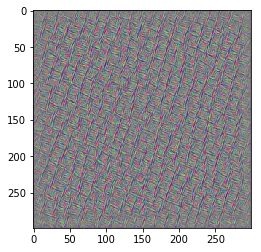

In [16]:
plot_image(image)

#### Optimize multiple images for convolutional layers

Layer: conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


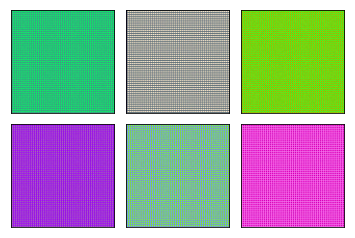

In [17]:
optimize_images(conv_id=0, num_iterations=10)

Layer: conv_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


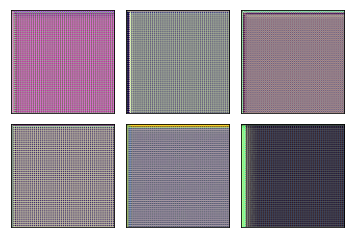

In [18]:
optimize_images(conv_id=1, num_iterations=30)

Layer: conv_2/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


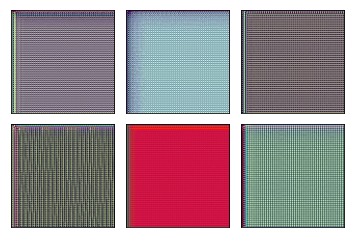

In [19]:
optimize_images(conv_id=2, num_iterations=30)

Layer: conv_3/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


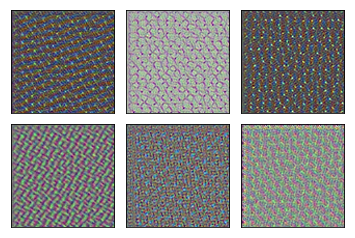

In [20]:
optimize_images(conv_id=3, num_iterations=30)

Layer: conv_4/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


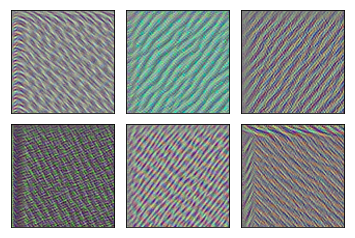

In [22]:
optimize_images(conv_id=4, num_iterations=30)

Layer: mixed/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


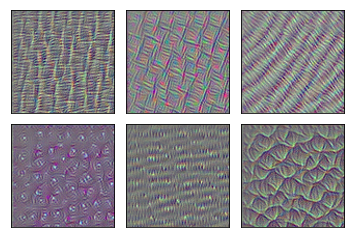

In [23]:
optimize_images(conv_id=5, num_iterations=30)

Layer: mixed/tower/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


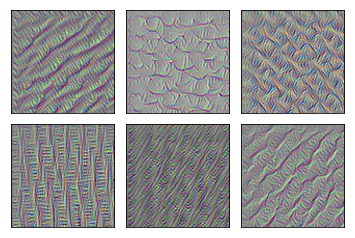

In [24]:
optimize_images(conv_id=6, num_iterations=30)

Layer: mixed/tower/conv_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


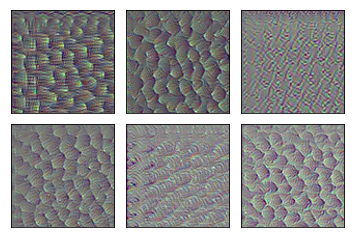

In [25]:
optimize_images(conv_id=7, num_iterations=30)

Layer: mixed/tower_1/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


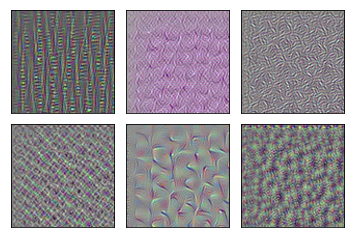

In [26]:
optimize_images(conv_id=8, num_iterations=30)

Layer: mixed/tower_1/conv_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


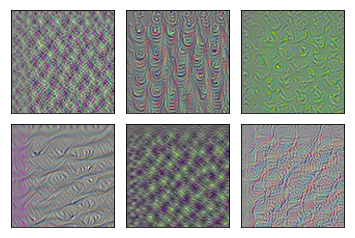

In [27]:
optimize_images(conv_id=9, num_iterations=30)

Layer: mixed/tower_1/conv_2/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


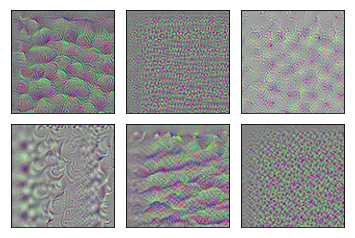

In [28]:
optimize_images(conv_id=10, num_iterations=30)

Layer: mixed_2/tower/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


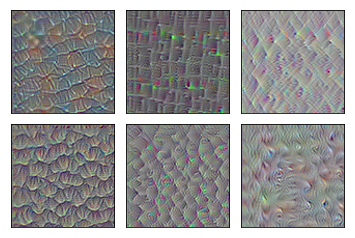

In [29]:
optimize_images(conv_id=20, num_iterations=30)

Layer: mixed_4/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


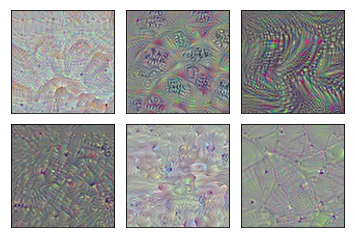

In [30]:
optimize_images(conv_id=30, num_iterations=30)

Layer: mixed_6/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


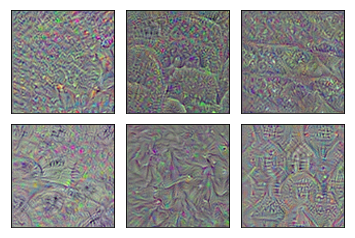

In [31]:
optimize_images(conv_id=50, num_iterations=30)

Layer: mixed_8/tower/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


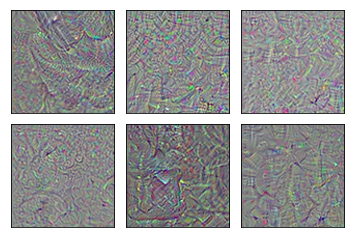

In [32]:
optimize_images(conv_id=70, num_iterations=30)

Layer: mixed_10/tower_1/conv_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


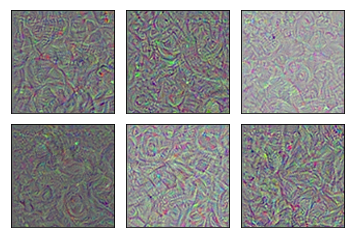

In [33]:
optimize_images(conv_id=90, num_iterations=30)

Layer: mixed_10/tower_2/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


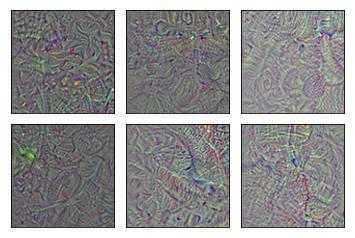

In [41]:
optimize_images(conv_id=93, num_iterations=30)

Final fully-connected layer before softmax.
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


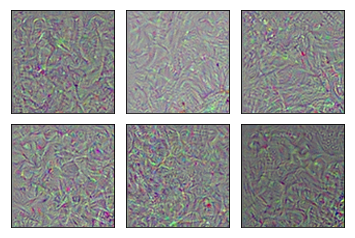

In [42]:
optimize_images(conv_id=None, num_iterations=30)

In [43]:
image = optimize_image(conv_id=None, feature=1,
                      num_iterations=100, show_progress=True)

Iteration: 0
Predicted class-name: dishwasher (#667), score:   5.13%
Gradient min: -0.004324, max:  0.003963, stepsize:   3904.65
Loss: -0.8447688

Iteration: 1
Predicted class-name: ballpoint (#907), score:   8.92%
Gradient min: -0.005608, max:  0.005269, stepsize:   2241.88
Loss: -0.5157798

Iteration: 2
Predicted class-name: spider web (#600), score:  95.88%
Gradient min: -0.008422, max:  0.009478, stepsize:   1667.82
Loss: 1.2467812

Iteration: 3
Predicted class-name: pot (#838), score:  12.47%
Gradient min: -0.005744, max:  0.007272, stepsize:   2197.88
Loss: 0.63266146

Iteration: 4
Predicted class-name: spider web (#600), score:  16.40%
Gradient min: -0.009323, max:  0.008036, stepsize:   1745.10
Loss: 4.8519597

Iteration: 5
Predicted class-name: spider web (#600), score:  16.64%
Gradient min: -0.005944, max:  0.008744, stepsize:   1831.82
Loss: 2.7012231

Iteration: 6
Predicted class-name: kit fox (#1), score:   9.76%
Gradient min: -0.007141, max:  0.006647, stepsize:   2155.4

Iteration: 58
Predicted class-name: kit fox (#1), score: 100.00%
Gradient min: -0.006205, max:  0.007115, stepsize:   1998.19
Loss: 45.945236

Iteration: 59
Predicted class-name: kit fox (#1), score: 100.00%
Gradient min: -0.015262, max:  0.012236, stepsize:   1330.86
Loss: 43.078495

Iteration: 60
Predicted class-name: kit fox (#1), score: 100.00%
Gradient min: -0.005376, max:  0.005981, stepsize:   1948.65
Loss: 47.09687

Iteration: 61
Predicted class-name: kit fox (#1), score: 100.00%
Gradient min: -0.018557, max:  0.017630, stepsize:   1273.25
Loss: 43.310795

Iteration: 62
Predicted class-name: kit fox (#1), score: 100.00%
Gradient min: -0.005503, max:  0.006558, stepsize:   2149.35
Loss: 52.170803

Iteration: 63
Predicted class-name: kit fox (#1), score: 100.00%
Gradient min: -0.005592, max:  0.005248, stepsize:   1915.60
Loss: 52.941723

Iteration: 64
Predicted class-name: kit fox (#1), score: 100.00%
Gradient min: -0.008444, max:  0.008314, stepsize:   1565.15
Loss: 51.893635



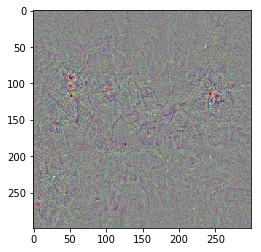

In [44]:
plot_image(image=image)